# Setup

In [1]:
DATA_FILE_NAME = "consultation-documents-preprocessed-2025-01-06.parquet"

LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

# EMBEDDING_MODEL = "openai/text-embedding-ada-002"
EMBEDDING_MODEL = "openai/text-embedding-3-large"

# FROM_YEAR = 2010
FROM_YEAR = 2000

MERGE_CLASSES = {
    # (classes, to, drop): replacement_class
    ("RESPONSE_FORM", "SURVEY", "SYNOPTIC_TABLE", "VARIOUS_TEXT"): "VARIOUS_TEXT",
}

INCLUDE_RULE_LABELS_IN_TRAINING = {"REPORT"}

CV_FOLDS = 5
TEST_SIZE = 0.1
RANDOM_STATE = 2718
USE_TEST_SET = False

%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db

env: MLFLOW_TRACKING_URI=sqlite:///mlruns.db


In [2]:
%load_ext autoreload
%autoreload 2

import logging
import pathlib
import sys
from typing import Any

import dotenv
import mlflow
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from tqdm import tqdm

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

In [3]:
from research.document_types import document_title_rule_model
from research.lib import data_access, embeddings, plotting

In [4]:
dotenv.load_dotenv()

True

In [5]:
mlflow.set_experiment(f"V1. {'&'.join(sorted(LANGUAGES))}. document types")

if run := mlflow.active_run():
    logging.warning("Run = %s is already active, closing it.", run.info.run_name)
    mlflow.end_run()
run = mlflow.start_run()
print("Starting run:", run.info.run_name)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("embedding_model", EMBEDDING_MODEL)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
;

Starting run: bald-perch-713


''

In [6]:
mlflow.sklearn.autolog()
tqdm.pandas()

2025/01/15 11:06:02 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.6.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

In [7]:
def merge_classes(series: pd.Series) -> pd.Series:
    """Apply the MERGE_CLASSES setting to a series of document type labels."""
    series = series.copy()
    for old_classes, new_class in MERGE_CLASSES.items():
        mask = series.isin(old_classes)
        series.loc[mask] = new_class
    return series

In [8]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

## Load Fedlex data (all of it is used for training)

In [9]:
df_fedlex = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE,
    only_document_sources={"fedlex"},
    only_languages=LANGUAGES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_fedlex

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '/Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-01-06.parquet'. Exception: 
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input da

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,document_type,document_language,document_title,organisation_id,organisation_name,political_body,consultation_reviewed_at,document_source,consultation_topics_label_source,document_content_plain
0,1,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",DRAFT,de,Vernehmlassungsvorlage,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...
3,4,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",RECIPIENT_LIST,de,Adressatenliste,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...
6,7,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",LETTER,de,Begleitschreiben 2,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...
9,10,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",REPORT,de,Erläuternder Bericht,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,1. Oktober 2021 \n \n \n \n \nVerordnung des B...
12,13,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",LETTER,de,Begleitschreiben 1,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52027,53636,4940,2024-12-20,2025-04-03,Indirekter Gegenvorschlag (Änderung des Kernen...,Das Verbot des Erteilens der Rahmenbewilligung...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/2b64exk2,"[energy, spatial_planning]",LETTER,de,Begleitschreiben,44,Bundesamt für Energie,ch,2024-11-05 11:39:50,fedlex,manual,Schweizerische Eidgenossenschaft\nConfëdëratio...
52030,53639,4940,2024-12-20,2025-04-03,Indirekter Gegenvorschlag (Änderung des Kernen...,Das Verbot des Erteilens der Rahmenbewilligung...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/2b64exk2,"[energy, spatial_planning]",LETTER,de,Begleitschreiben-2,44,Bundesamt für Energie,ch,2024-11-05 11:39:50,fedlex,manual,Schweizerische Eidgenossenschaft\nConfëdëratio...
52033,53642,4940,2024-12-20,2025-04-03,Indirekter Gegenvorschlag (Änderung des Kernen...,Das Verbot des Erteilens der Rahmenbewilligung...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/2b64exk2,"[energy, spatial_planning]",REPORT,de,Erläuternder Bericht,44,Bundesamt für Energie,ch,2024-11-05 11:39:50,fedlex,manual,BFE-D-BDD93401/157\n \nEidgenössisches Departe...
52036,53645,4940,2024-12-20,2025-04-03,Indirekter Gegenvorschlag (Änderung des Kernen...,Das Verbot des Erteilens der Rahmenbewilligung...,https://fedlex.data.admin.ch/filestore/fedlex....,https:/

## Load OpenParlData and generate labels by the rule model

In [10]:
df_opd = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE,
    only_document_sources={"openparldata"},
    only_languages=LANGUAGES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_opd

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '/Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-01-06.parquet'. Exception: 
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input da

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,document_type,document_language,document_title,organisation_id,organisation_name,political_body,consultation_reviewed_at,document_source,consultation_topics_label_source,document_content_plain
38324,38325,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,Beilage 1 zum Anhörungsbericht (Statuten) (PDF...,141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,Beilage 1 \nVerabschiedet durch Politisches Gr...
38325,38326,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,Beilage 2 zum Anhörungsbericht (Aktionärbindun...,141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,"Stand: 20. November 2018, mit formalen Ergänzu..."
38326,38327,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,Beilage 3 zum Anhörungsbericht (Eignerstrategi...,141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,Seite 1 von 2 Stand: 20. November 2018 \n\nEig...
38327,38328,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,Beilage 4 zum Anhörungsbericht (NOK-Gründungsv...,141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,731.120\n\nSchaffhauser Rechtsbuch 1997 1\n\nV...
38328,38329,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,"Anhörungsbericht (PDF, 10 Seiten, 184 KB)",141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,J:\03_Geschäfte\1_Vorträge\05_AE\Auflösung NOK...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52007,53616,4991,2024-12-18,2025-02-20,Bericht «Sonderpädagogik der St.Galler Volkssc...,Die Regierung des Kantons St.Gallen hat an ihr...,https://www.sg.ch/news/sgch_allgemein/2024/12/...,https://www.demokratis.ch/vernehmlassung/4tpw3ygc,[education],VARIOUS_TEXT,de,Bericht Sonderpädagogik der St.Galler Volksschule,156,Regierung des Kantons St. Gallen,sg,NaT,openparldata,openparldata,Kanton St.Gallen \nBildungsdepartement \n \nAm...
52008,53617,4991,2024-12-18,2025-02-20,Bericht «Sonderpädagogik der St.Galler Volkssc...,Die Regierung des Kantons St.Gallen hat an ihr...,https://www.sg.ch/news/sgch_allgemein/2024/12/...,https://www.demokratis.ch/vernehmlassung/4tpw3ygc,[education],VARIOUS_TEXT,de,Anhang 1: Bericht der Paedagogischen Hochschul...,156,Regierung des Kantons St. Gallen,sg,NaT,openparldata,openparldata,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...
52039,53648,4994,2024-12-19,2025-03-19,Vernehmlassung zum Erlass eines Gesetzes über ...,Die Bündner Regierung hat im Rahmen der Teilre...,https://www.gr.ch/DE/publikationen/vernehmlass...,https://www.demokratis.ch/vernehmlassung/v3tefzb7,[education],VARIOUS_TEXT,de,Einladungsschreiben,150,Regierung des Kantons Graubünden,gr,NaT,openparldata,openparldata,"info@ekud.gr.ch \nwww.ekud.gr.ch\nErziehungs-,..."
52040,53649,4994,2024-12-19,2025-03-19,Vernehmlassung zum Erlass eines Gesetzes über ...,Die Bündner Regierung hat im Rahmen der Teilre...,https://www.gr.ch/DE/publikationen/vernehmlass...,https://www.demokratis.ch/vernehmlassung/v3tefzb7,[education],VARIOUS_TEXT,de,Erlass,150,Regierung des Kantons Graubünden,gr,NaT,openparlda

In [11]:
# Generate rule-labels (predictions)
df_opd["prediction_rule"] = document_title_rule_model.predict(df_opd)

# Split OpenParlData: only pick certain rule-labels for training. The rest will be used for testing.
opd_train_index = df_opd["prediction_rule"].isin(INCLUDE_RULE_LABELS_IN_TRAINING)
df_opd_train = df_opd.loc[opd_train_index].copy()
df_opd_test = df_opd.loc[~opd_train_index].copy()
del df_opd  # Prevent mistakes; we should only explicitly access the train or the test set from now on.

# Normalise the training portion: use the rule-label as the canonical target label.
del df_opd_train["document_type"]
df_opd_train = df_opd_train.rename(columns={"prediction_rule": "document_type"})

print(f"Adding {len(df_opd_train)} OpenParlData documents to the training set:")
df_opd_train["document_type"].value_counts(dropna=False)

Adding 1268 OpenParlDocuments to the training set:


document_type
REPORT    1268
Name: count, dtype: int64

## Create the input dataframe from Fedlex and a part of OpenParlData

In [12]:
df_input = pd.concat([df_fedlex, df_opd_train], ignore_index=True)

In [13]:
df_input["document_type"].value_counts(dropna=False)

document_type
REPORT            3421
LETTER            3084
DRAFT             2898
RECIPIENT_LIST    1770
FINAL_REPORT      1747
OPINION            985
VARIOUS_TEXT       418
SYNOPTIC_TABLE      81
SURVEY              13
RESPONSE_FORM        7
Name: count, dtype: int64

## Merge classes

In [14]:
df_input["document_type"] = merge_classes(df_input["document_type"])
df_input["document_type"].value_counts(dropna=False)

document_type
REPORT            3421
LETTER            3084
DRAFT             2898
RECIPIENT_LIST    1770
FINAL_REPORT      1747
OPINION            985
VARIOUS_TEXT       519
Name: count, dtype: int64

## Define the target

In [15]:
y_encoder = OrdinalEncoder(dtype=int)
df_input["document_type_code"] = y_encoder.fit_transform(df_input[["document_type"]])

## Drop empty documents

In [16]:
empty_index = df_input["document_content_plain"].str.strip() == ""
empty_count = len(df_input[empty_index])
print(f"Empty texts: {empty_count} ({100 * empty_count / len(df_input):.1f}%)")

Empty texts: 734 (5.1%)


In [17]:
df_input = df_input.loc[~empty_index]

## Splits

### Set aside a test set

In [18]:
splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train_index, test_index = next(splitter.split(X=df_input, y=df_input["document_type_code"]))

In [19]:
df_input_train = df_input.iloc[train_index]
df_input_test = df_input.iloc[test_index]

print("Train:", df_input_train.shape)
print("Test:", df_input_test.shape)

Train: (12321, 20)
Test: (1369, 20)


In [20]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

1369

### Prepare a cross-validation splitter

In [21]:
cv_splitter = sklearn.model_selection.StratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)

# Embeddings

## Tokenise and truncate to input window

In [22]:
embedding_model = embeddings.create_embedding_model(EMBEDDING_MODEL)
mlflow.log_param("embedding_model.max_input_tokens", embedding_model.max_input_tokens)

tokens_train = df_input_train["document_content_plain"].progress_map(embedding_model.tokenize)
tokens_test = df_input_test["document_content_plain"].progress_map(embedding_model.tokenize)

100%|██████████| 1369/1369 [00:04<00:00, 288.87it/s]


## Embed

In [23]:
with embeddings.use_cache(
    embedding_model,
    tqdm=tqdm,
    cache_directory=REPOSITORY_ROOT / "data" / "embeddings-cache",
    read_only=True,
) as get_embeddings:
    embeddings_train = get_embeddings(tokens_train.tolist())
    print(embeddings_train.shape)
    embeddings_test = get_embeddings(tokens_test.tolist())
    print(embeddings_test.shape)

Embedding (cached=12320, new=0): 100%|██████████| 12321/12321 [00:08<00:00, 1448.53it/s]


(12321, 3072)


Embedding (cached=1368, new=0): 100%|██████████| 1369/1369 [00:00<00:00, 1403.57it/s]

(1369, 3072)


# Classification

In [24]:
X_train = embeddings_train
X_test = embeddings_test
y_train = df_input_train["document_type_code"]
y_test = df_input_test["document_type_code"]

print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Train (12321, 3072) (12321,)
Test (1369, 3072) (1369,)


In [25]:
classifier = make_pipeline(
    StandardScaler(),
    # PCA(n_components=200, random_state=RANDOM_STATE),
    LogisticRegression(max_iter=1000),
)
classifier

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [26]:
if "pca" in classifier.named_steps:
    mlflow.log_param("pca_n_components", classifier.named_steps["pca"].get_params()["n_components"])

In [27]:
def explained_variance_scorer(pipeline: Pipeline, X: Any, y: Any = None) -> np.float64:
    try:
        pca = pipeline.named_steps["pca"]
    except KeyError:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted",
    "pca_explained_variance": explained_variance_scorer,
}

scores_docs = sklearn.model_selection.cross_validate(
    classifier,
    X=X_train,
    y=y_train,
    cv=cv_splitter,
    scoring=scoring,
)
scores_docs

{'fit_time': array([1.01073575, 0.94277   , 0.94273996, 0.94314122, 0.93525696]),
 'score_time': array([0.02591205, 0.02101803, 0.02115202, 0.02180099, 0.02065492]),
 'test_precision': array([0.9588123 , 0.95742542, 0.96471757, 0.95821681, 0.95747294]),
 'test_recall': array([0.95983773, 0.95819805, 0.9650974 , 0.95941558, 0.9586039 ]),
 'test_f1': array([0.95893377, 0.95773241, 0.96483318, 0.95870955, 0.95757906]),
 'test_pca_explained_variance': array([nan, nan, nan, nan, nan])}

## Evaluation of the cross-validation

In [28]:
avg_scores_docs = {k: np.round(np.mean(v), 4) for k, v in scores_docs.items()}
mlflow.log_metrics({f"{k}_docs": v for k, v in avg_scores_docs.items() if k.startswith("test_")})

print("Per-document CV scores:")
print(f"Precision: {avg_scores_docs['test_precision']:.4f} (+/- {np.std(scores_docs['test_precision']):.4f})")
print(f"Recall:    {avg_scores_docs['test_recall']:.4f} (+/- {np.std(scores_docs['test_recall']):.4f})")
print(f"F1:        {avg_scores_docs['test_f1']:.4f} (+/- {np.std(scores_docs['test_f1']):.4f})")

Per-document CV scores:
Precision: 0.9593 (+/- 0.0027)
Recall:    0.9602 (+/- 0.0025)
F1:        0.9596 (+/- 0.0027)


### Use subsets of the training set to re-train and evaluate. This gives us a single model to run reports on. 

In [29]:
cv_test_splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

cv_train_index, cv_test_index = next(cv_test_splitter.split(X=X_train, y=y_train))

X_cv_train = X_train[cv_train_index]
y_cv_train = y_train.iloc[cv_train_index]
X_cv_test = X_train[cv_test_index]
y_cv_test = y_train.iloc[cv_test_index]

In [30]:
classifier.fit(X_cv_train, y_cv_train)
cv_test_predictions = classifier.predict(X_cv_test)

2025/01/15 11:08:38 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/01/15 11:08:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


                precision    recall  f1-score   support

         DRAFT       0.94      0.95      0.94       260
  FINAL_REPORT       0.99      0.99      0.99       157
        LETTER       0.99      1.00      0.99       221
       OPINION       1.00      0.98      0.99        87
RECIPIENT_LIST       0.99      1.00      1.00       158
        REPORT       0.95      0.98      0.96       304
  VARIOUS_TEXT       0.85      0.63      0.72        46

      accuracy                           0.97      1233
     macro avg       0.96      0.93      0.94      1233
  weighted avg       0.96      0.97      0.96      1233



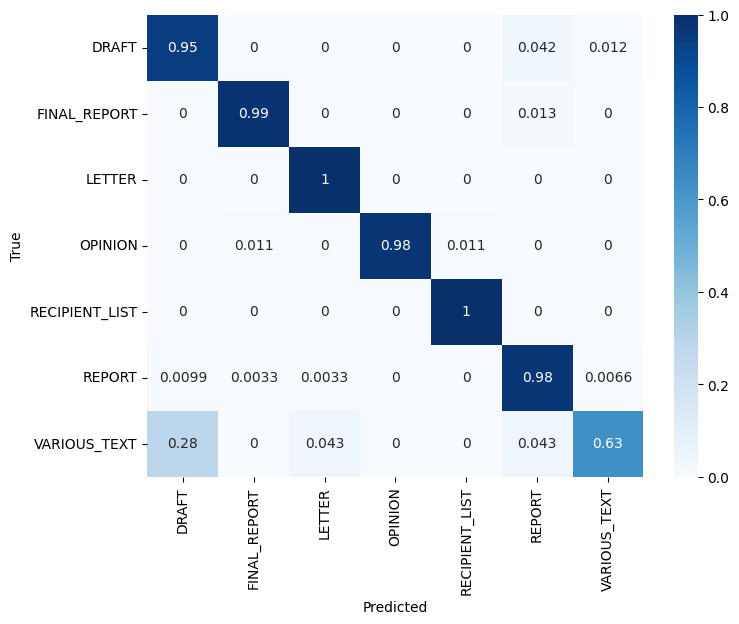

In [31]:
target_names = y_encoder.categories_[0]
print(
    sklearn.metrics.classification_report(
        y_cv_test,
        cv_test_predictions,
        target_names=target_names,
        labels=range(len(target_names)),
    )
)

display(plotting.plot_confusion_matrix_heatmap(y_cv_test, cv_test_predictions, target_names=target_names))

***

## Evaluation on the test set (USE SPARINGLY)

In [32]:
if USE_TEST_SET:
    classifier.fit(X_train, y_train)
    test_ground_truth_docs = y_test
    test_predictions_docs = classifier.predict(X_test)

    print("docs: ground truth", test_ground_truth_docs.shape)
    print("docs: predictions", test_predictions_docs.shape)

    print(
        sklearn.metrics.classification_report(
            test_ground_truth_docs,
            test_predictions_docs,
            target_names=y_encoder.categories_[0],
            labels=range(len(y_encoder.categories_[0])),
        )
    )

In [33]:
if USE_TEST_SET:
    display(
        plotting.plot_confusion_matrix_heatmap(
            test_ground_truth_docs, test_predictions_docs, target_names=y_encoder.categories_[0]
        )
    )

***

# Rule-based & ML model evaluation

## Embed the OpenParlData test set

In [34]:
tokens_opd_test = df_opd_test["document_content_plain"].progress_map(embedding_model.tokenize)

with embeddings.use_cache(
    embedding_model,
    tqdm=tqdm,
    cache_directory=REPOSITORY_ROOT / "data" / "embeddings-cache",
    read_only=True,
) as get_embeddings:
    embeddings_opd_test = get_embeddings(tokens_opd_test.tolist())
    print(embeddings_opd_test.shape)

Embedding (cached=8582, new=0): 100%|██████████| 8583/8583 [00:04<00:00, 1869.78it/s]

(8583, 3072)


In [35]:
df_opd_test["embedding"] = embeddings_opd_test.tolist()

## Merge classes in the test set

In [36]:
df_opd_test["document_type"] = merge_classes(df_opd_test["document_type"])

## Test both the rule-based model and the sklearn model on a sample of OpenParlData

In [37]:
# Option A: random sample
# sample_batch = df_opd_test.sample(10)

# Option B: Use the same sample batch for now: the one where we've manually added ground truth labels
ground_truth = pd.read_excel(REPOSITORY_ROOT / "research" / "document_types" / "ground_truth.xlsx")[
    ["document_id", "ground_truth"]
].set_index("document_id")
ground_truth["ground_truth"] = merge_classes(ground_truth["ground_truth"])

ground_truth = ground_truth.dropna()

sample_batch = df_opd_test[df_opd_test["document_id"].isin(ground_truth.index)].copy()
print(len(sample_batch))

68


Use both models to generate predictions:

In [38]:
sample_batch["prediction_rule"] = merge_classes(document_title_rule_model.predict(sample_batch))

sample_predictions = classifier.predict(sample_batch["embedding"].tolist())
sample_batch["prediction_ml"] = y_encoder.inverse_transform(sample_predictions.reshape(-1, 1)).reshape(1, -1)[0]

2025/01/15 11:09:05 WARNING mlflow.sklearn: Unrecognized dataset type <class 'list'>. Dataset logging skipped.


(Sample option A only) Copy the sample to the clipboard...

In [39]:
# sample_batch[["document_id", "document_source_url", "document_title"]].to_clipboard(index=False)

(Sample option A only)  ...after adding the true labels, run this to load them back in here:

In [40]:
# ground_truth = pd.read_excel(REPOSITORY_ROOT / "research" / "document_types" / "ground_truth.xlsx")[
#     ["document_id", "ground_truth"]
# ].set_index("document_id")

### Display all samples

In [41]:
sample_batch_with_ground_truth = sample_batch.join(ground_truth, on="document_id")

sample_batch_with_ground_truth[
    [
        "document_id",
        "political_body",
        "consultation_url",
        "document_source_url",
        "document_title",
        "ground_truth",
        "prediction_rule",
        "prediction_ml",
    ]
].style.format(
    {
        "consultation_url": lambda x: f'<a href="{x}">vnl</a>',
        "document_source_url": lambda x: f'<a href="{x}">doc</a>',
    }
).set_table_styles([{"selector": "th,td", "props": [("text-align", "left")]}])

,document_id,political_body,consultation_url,document_source_url,document_title,ground_truth,prediction_rule,prediction_ml
38521,38522,ag,vnl,doc,"Beilage 1 zum Anhörungsbericht (PDF, 84 Seiten, 717 KB)",VARIOUS_TEXT,VARIOUS_TEXT,REPORT
38664,38688,ag,vnl,doc,"Schreiben der Vorsteherin (PDF, 2 Seiten, 32 KB)",LETTER,LETTER,LETTER
38747,38771,ag,vnl,doc,"Anpassung allgemeine Nutzungsplanung (PDF, 52 Seiten, 6,1 MB)",REPORT,None,REPORT
38830,38854,ag,vnl,doc,"Adressatenliste (PDF, 5 Seiten, 26 KB)",RECIPIENT_LIST,RECIPIENT_LIST,RECIPIENT_LIST
39074,39098,ag,vnl,doc,"Beilage 3 zum Anhörungsbericht (Synopse GGV) (PDF, 2 Seiten, 81 KB)",VARIOUS_TEXT,VARIOUS_TEXT,REPORT
39240,39264,ag,vnl,doc,"Schreiben des Vorstehers (PDF, 2 Seiten, 1,5 MB)",LETTER,LETTER,VARIOUS_TEXT
39253,39277,ag,vnl,doc,Link zum Fragebogen,VARIOUS_TEXT,None,VARIOUS_TEXT
39348,39372,ag,vnl,doc,"Fragebogen (nicht ausfüllbar) (PDF, 6 Seiten, 140 KB)",VARIOUS_TEXT,VARIOUS_TEXT,REPORT
39623,39759,ai,vnl,doc,Entwurf Verordnung über die Nutzung des Untergrundes (VNU),DRAFT,DRAFT,VARIOUS_TEXT
39706,39842,ai,vnl,doc,Entwurf Landsgemeindebeschluss über die Revision der Gerichtsorganisationsbestimmungen,DRAFT,DRAFT,REPORT


In [42]:
# sample_batch.loc[sample_batch["document_id"] == 48487]

In [43]:
sample_batch_with_ground_truth["ground_truth"].value_counts(dropna=False)

ground_truth
VARIOUS_TEXT      25
DRAFT             17
LETTER            10
RECIPIENT_LIST     7
REPORT             5
FINAL_REPORT       4
Name: count, dtype: int64

### ML model vs. ground truth

In [44]:
print(
    sklearn.metrics.classification_report(
        sample_batch_with_ground_truth["ground_truth"],
        sample_batch_with_ground_truth["prediction_ml"],
        zero_division=np.nan,
    )
)

                precision    recall  f1-score   support

         DRAFT       0.55      0.35      0.43        17
  FINAL_REPORT        nan      0.00      0.00         4
        LETTER       1.00      0.80      0.89        10
       OPINION       0.00       nan      0.00         0
RECIPIENT_LIST       1.00      0.86      0.92         7
        REPORT       0.18      1.00      0.30         5
  VARIOUS_TEXT       0.62      0.32      0.42        25

      accuracy                           0.49        68
     macro avg       0.56      0.56      0.42        68
  weighted avg       0.66      0.49      0.51        68



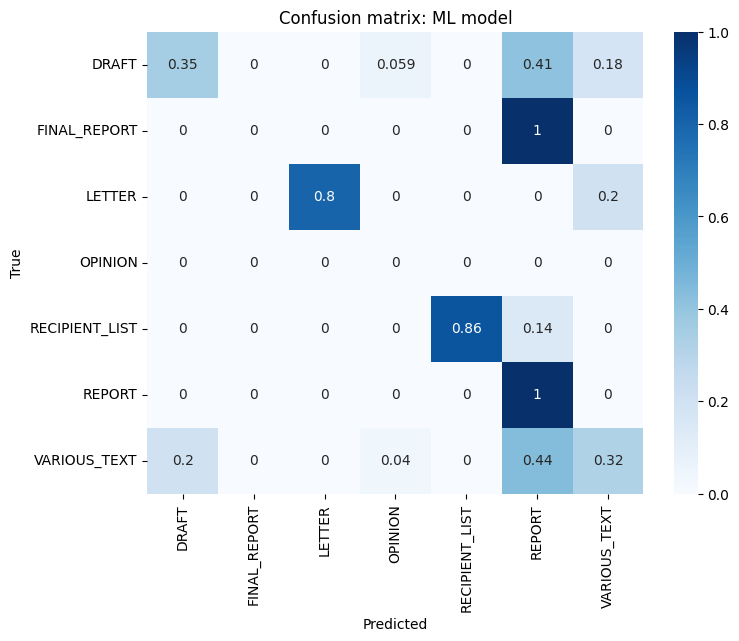

In [45]:
plotting.plot_confusion_matrix_heatmap(
    sample_batch_with_ground_truth["ground_truth"],
    sample_batch_with_ground_truth["prediction_ml"],
    target_names=target_names,
    title="ML model",
)

### Rule-based model vs. ground truth

In [46]:
_df = sample_batch_with_ground_truth[sample_batch_with_ground_truth["prediction_rule"].notna()]
print(sklearn.metrics.classification_report(_df["ground_truth"], _df["prediction_rule"], zero_division=np.nan))

                precision    recall  f1-score   support

         DRAFT       0.89      0.80      0.84        10
  FINAL_REPORT       1.00      0.50      0.67         2
        LETTER       1.00      1.00      1.00        10
RECIPIENT_LIST       1.00      0.80      0.89         5
  VARIOUS_TEXT       0.79      0.94      0.86        16

      accuracy                           0.88        43
     macro avg       0.94      0.81      0.85        43
  weighted avg       0.90      0.88      0.88        43



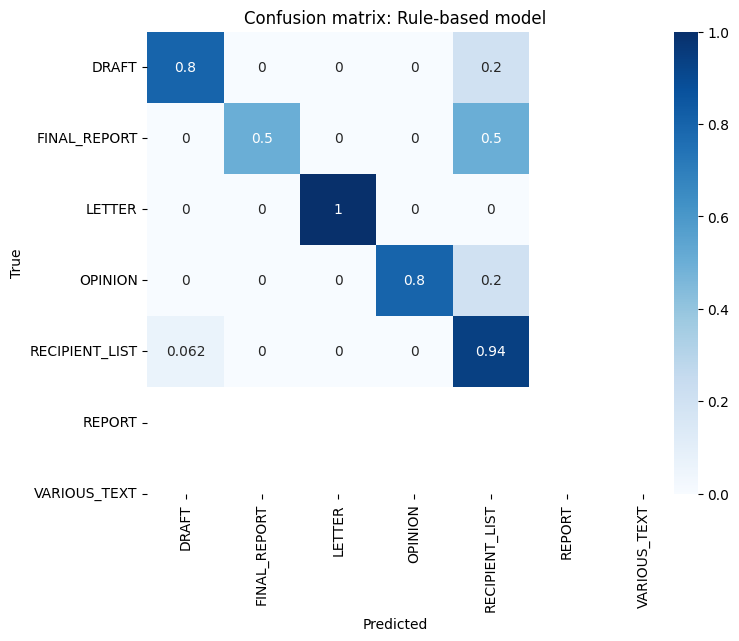

In [47]:
plotting.plot_confusion_matrix_heatmap(
    _df["ground_truth"], _df["prediction_rule"], target_names=target_names, title="Rule-based model"
)

***

# End MLflow run

In [48]:
mlflow.end_run()